In [1]:
# Importing libraries

import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Uploading data

df1 = pd.read_csv(r'B:\results.csv', sep=';')
df2 = pd.read_csv(r'B:\User_id.csv')
df3 = pd.read_excel(r'B:\Mobidot\export-1641679263.xlsx')


C:\Users\jeanm\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [2]:
# Adding date attributes to data

df1['date'] = df1['trip_time'].apply(lambda x: datetime.datetime.strptime(x + '00', "%Y-%m-%d %H:%M:%S%z"))
df1['date'] = pd.to_datetime(df1['date'], errors='coerce', utc = True)
df1['day'] = df1.date.dt.strftime('%a')
df1['month'] = df1.date.dt.strftime('%B')
df1['hour'] = df1.date.dt.strftime('%H')
df1['date_1'] = df1.date.dt.strftime('%x')
user_id = []
for i in df1.user_id.unique():
    user = df1[df1.user_id == i].date_1.unique()
    if len(user) > 85:
        user_id.append(i)
df1 = df1[df1.user_id.isin(user_id) == False] 


In [3]:
# Cleaning data 

df1 = df1[((df1['trip_objective'] == 'Shopping') | (df1['trip_objective'] == 'RoundTrip')) & ((df1['destination_type'] == 'supermarket') & (df1['destination_country'] == 'Nederland'))]
df1 = df1[df1.journey_desttype == 'supermarket']
df1['velocity'] = (df1['trip_distance'] / 1000) / (df1['trip_duration'] / 3600)


In [4]:
# Function to add two consecutive shopping times (Assumption: data is recorded twice, however, it is same trip)

def add_shopping_time(data_set):
    added_time = []
    index = []
    index_to_delete = []
    for i in range(len(data_set) - 1):
        if (data_set['trip_modality'][data_set.index[i]] == 'Stay' and data_set['trip_modality'][data_set.index[i+1]] == 'Stay') and (data_set.index[i] == data_set.index[i+1]):
            trip_duration = data_set['trip_duration'][data_set.index[i]] + data_set['trip_duration'][data_set.index[i+1]]
            data_set['trip_duration'][data_set.index[i]] = trip_duration
            index_to_delete.append(data_set.index[i+1])
        else: 
            if data_set['trip_modality'][data_set.index[i]] == 'Stay' and data_set['trip_modality'][data_set.index[i+1]] == 'Stay':
                index_to_delete.append(data_set.index[i+1])
    data_set = data_set.drop(index = index_to_delete)
    data_set['shopping_time'] = 0
    return data_set


In [5]:
# Funtion to add shopping time per trip

def shopping_time(data_set):
    shopping_times = []
    index = []
    for i in range(len(data_set)-1):
        if data_set['trip_modality'][data_set.index[i]] != 'Stay' and data_set['trip_modality'][data_set.index[i+1]] == 'Stay':
            data_set['shopping_time'][data_set.index[i]] = data_set['trip_duration'][data_set.index[i+1]]
        else:
            data_set['shopping_time'][data_set.index[i]] = np.nan

    data_set = data_set[data_set.trip_modality != 'Stay'] 
    data_set = data_set[data_set.trip_modality != 'Stay@office'] 

    return data_set


In [6]:
# Funtion to merge datasets 

def merge_data(dataset_1, dataset_2, dataset_3):
    dataset = dataset_1.reset_index().merge(dataset_2, how="left").set_index('index')
    user = dataset.reset_index().merge(dataset_3, left_on="tracker_id", right_on='ID', how="left").set_index('index')
    user = user.drop_duplicates()
    user = user.drop(['distance', 'home_duration', 'tracker_id', 'ID'], axis = 1)
    return user


In [7]:
# Translating variable names to english

def translation(data_set):
    return data_set.rename(columns = {'Leeftijd':'Age', 'Geslacht':'Gender', 'Stedelijkheid':'City_density', 'Gezinscyclus (kort)':'House_composition', 'Opleiding voltooid':'Education_level',
                              'Werkzaamheid':'Profession', 'Autobezit':'Car_ownership', 'Grootte huishouden':'Household_size', 'Bruto jaarinkomen huishouden (kort)':'Anual_income', 'Rijbewijsbezit':'Driving_license'})


In [8]:
df1 = add_shopping_time(df1)
df1 = shopping_time(df1)


C:\Users\jeanm\AppData\Local\Temp\ipykernel_11916\1409796997.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['shopping_time'][data_set.index[i]] = data_set['trip_duration'][data_set.index[i+1]]
C:\Users\jeanm\AppData\Local\Temp\ipykernel_11916\1409796997.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['shopping_time'][data_set.index[i]] = np.nan


In [9]:
# Checkpoint

df = df1


In [10]:
# Record inconsistent trips
inconsistent = pd.DataFrame()
inconsistent = inconsistent.append(df[df['shopping_time'] > 5400])
inconsistent = inconsistent.append(df[df['shopping_time'] < 30])
inconsistent = inconsistent.append(df[df['velocity'] > 150])
inconsistent = inconsistent.append(df[df['trip_duration'] > 4000])
inconsistent = inconsistent.append(df[df['trip_distance'] > 25000])
inconsistent = inconsistent.drop_duplicates()
df = df.drop(index = inconsistent.index)
df = df.dropna(subset = ['shopping_time'])

df = merge_data(df, df2, df3)
df = translation(df)
df = df.dropna(subset = ['Age'])


C:\Users\jeanm\AppData\Local\Temp\ipykernel_11916\373138424.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inconsistent = inconsistent.append(df[df['shopping_time'] > 5400])
C:\Users\jeanm\AppData\Local\Temp\ipykernel_11916\373138424.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inconsistent = inconsistent.append(df[df['shopping_time'] < 30])
C:\Users\jeanm\AppData\Local\Temp\ipykernel_11916\373138424.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inconsistent = inconsistent.append(df[df['velocity'] > 150])
C:\Users\jeanm\AppData\Local\Temp\ipykernel_11916\373138424.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inc

In [11]:
df['Gender'] = df['Gender'].replace([1, 2],['Male','Female'])
df['City_density'] = df['City_density'].replace([1.0, 2.0, 3.0, 4.0, 5.0],['High_density','High_density', 'Medium_density', 'Low_density', 'Low_density'])
df['Education_level'] = df['Education_level'].replace([1, 2, 3, 4, 5, 6, 7, 8],['Middle_school_or_below','Middle_school_or_below'
                        , 'High_school', 'Bachelor_education_or_above', 'High_school', 'Bachelor_education_or_above', 'Bachelor_education_or_above',
                            'Unknow'])
df['Profession'] = df['Profession'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9],['Entrepreneur','Employed', 'Governmental',
                        'Incapacitated', 'Unemployed', 'Retired', 'Studying', 'At_home', 'Unknow'])
df['House_composition'] = df['House_composition'].replace([0, 1, 2, 11, 12],['Unknown','Single', 'Adult_household',
                                'With_young_children', 'With_adolescent_children'])

df['Car_ownership'] = df['Car_ownership'].replace([1, 2, 0],['Yes','No', 'Unknwon'])
df['Anual_income'] = df['Anual_income'].replace([1, 2, 3, 5, 6, 7, 9],['Low_income','Low_income', 'Modal', 'High_income',
                            'High_income', 'High_income', 'Unkwnown'])
df['Driving_license'] = df['Car_ownership'].replace([1, 2, 0],['Yes','No', 'Unknwon'])


In [12]:
df['num_trips'] = df['user_id'].apply(lambda x: int((len(df[df['user_id'] == x]))))
df = df.drop(index = df[df.num_trips > 78].index)
df = df.drop(index = df[df.num_trips <= 1].index)


In [13]:
df = df.drop(index = df[df.trip_modality == 'PublicTransport'].index)
df = df.drop(index = df[df.trip_modality == 'Other'].index)

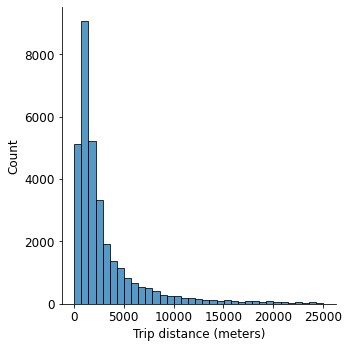

In [35]:
ax = sns.displot(df['trip_distance'], kde = False, bins = 35)
ax.set(xlabel = 'Trip distance (meters)', ylabel = 'Count')

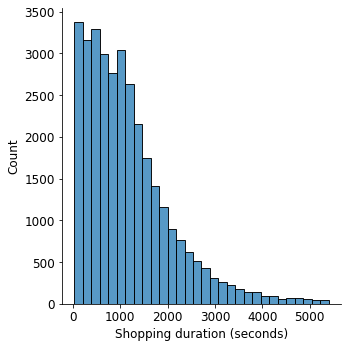

In [36]:
ax = sns.displot(df['shopping_time'], kde = False, bins = 30)
ax.set(xlabel = 'Shopping duration (seconds)', ylabel = 'Count')

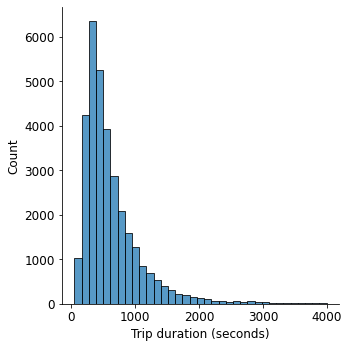

In [37]:
ax = sns.displot(df['trip_duration'], kde = False, bins = 35)
ax.set(xlabel = 'Trip duration (seconds)', ylabel = 'Count')

In [17]:
df.columns

Index(['trip_id', 'user_id', 'trip_time', 'trip_type', 'trip_modality',
       'trip_distance', 'chain_type', 'chain_objective', 'trip_objective',
       'journey_type', 'journey_desttype', 'chain_id', 'journey_id',
       'journey_time0', 'journey_time1', 'journey_dist', 'journey_objective',
       'journey_source', 'stay_overnight_id', 'stay_overnight_type',
       'trip_duration', 'destination_osm_id', 'destination_type',
       'destination_country', 'destination_city', 'destination_latitude',
       'destination_longitude', 'stay_place_id', 'date', 'day', 'month',
       'hour', 'date_1', 'velocity', 'shopping_time', 'Postcode 4', 'Age',
       'Gender', 'City_density', 'House_composition', 'Education_level',
       'Profession', 'Car_ownership', 'Household_size', 'Anual_income',
       'Driving_license', 'num_trips'],
      dtype='object')

In [18]:
df['num_trips'] = df['num_trips'] / 3

In [19]:
df['num_trips'] = df['num_trips'].astype(int)
df['num_trips'] = df['num_trips'].replace(0,1)


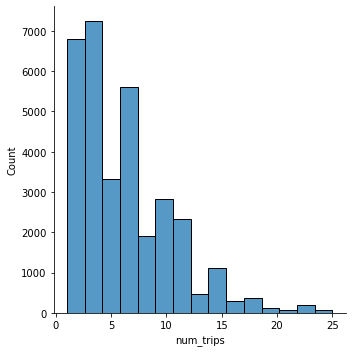

In [20]:
sns.displot(df['num_trips'], kde = False, bins = 15)


In [22]:
df.columns

Index(['trip_id', 'user_id', 'trip_time', 'trip_type', 'trip_modality',
       'trip_distance', 'chain_type', 'chain_objective', 'trip_objective',
       'journey_type', 'journey_desttype', 'chain_id', 'journey_id',
       'journey_time0', 'journey_time1', 'journey_dist', 'journey_objective',
       'journey_source', 'stay_overnight_id', 'stay_overnight_type',
       'trip_duration', 'destination_osm_id', 'destination_type',
       'destination_country', 'destination_city', 'destination_latitude',
       'destination_longitude', 'stay_place_id', 'date', 'day', 'month',
       'hour', 'date_1', 'velocity', 'shopping_time', 'Postcode 4', 'Age',
       'Gender', 'City_density', 'House_composition', 'Education_level',
       'Profession', 'Car_ownership', 'Household_size', 'Anual_income',
       'Driving_license', 'num_trips'],
      dtype='object')

In [23]:
df.head()

,trip_id,user_id,trip_time,trip_type,trip_modality,trip_distance,chain_type,chain_objective,trip_objective,journey_type,journey_desttype,chain_id,journey_id,journey_time0,journey_time1,journey_dist,journey_objective,journey_source,stay_overnight_id,stay_overnight_type,trip_duration,destination_osm_id,destination_type,destination_country,destination_city,destination_latitude,destination_longitude,stay_place_id,date,day,month,hour,date_1,velocity,shopping_time,Postcode 4,Age,Gender,City_density,House_composition,Education_level,Profession,Car_ownership,Household_size,Anual_income,Driving_license,num_trips
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
214,11212458004,1112,2022-03-27 13:00:03+02,EnRoute,Car,2300,home-home,Shopping,Shopping,journey,supermarket,1.121249e+10,1.121246e+10,2022-03-27 13:00:03+02,2022-03-27 13:06:44+02,2300.0,Shopping,PersonalPlace,81710970,home,402,397358644.0,supermarket,Nederland,Spijkenisse,51.842110,4.324068,NaN,2022-03-27 11:00:03+00:00,Sun,March,11,03/27/22,20.597015,1268.0,3205.0,36.0,Male,High_density,With_young_children,Bachelor_education_or_above,Employed,Unknwon,5.0,High_income,Unknwon,1
311,11336275068,1112,2022-04-04 18:13:06+02,EnRoute,Car,4400,home-home,Shopping,Shopping,journey,supermarket,1.133628e+10,1.133628e+10,2022-04-04 18:03:30+02,2022-04-04 18:25:06+02,8700.0,Shopping,PersonalPlace,81710970,home,721,397358644.0,supermarket,Nederland,Spijkenisse,51.842110,4.324068,NaN,2022-04-04 16:13:06+00:00,Mon,April,16,04/04/22,21.969487,412.0,3205.0,36.0,Male,High_density,With_young_children,Bachelor_education_or_above,Employed,Unknwon,5.0,High_income,Unknwon,1
594,11969817381,1112,2022-05-10 18:33:37+02,EnRoute,Car,1700,home-home,Shopping,Shopping,journey,supermarket,1.196983e+10,1.196982e+10,2022-05-10 18:33:37+02,2022-05-10 18:38:23+02,1700.0,Shopping,PersonalPlace,81710970,home,287,269323589.0,supermarket,Nederland,Spijkenisse,51.828285,4.327097,NaN,2022-05-10 16:33:37+00:00,Tue,May,16,05/10/22,21.324042,956.0,3205.0,36.0,Male,High_density,With_young_children,Bachelor_education_or_above,Employed,Unknwon,5.0,High_income,Unknwon,1
854,11240948941,1135,2022-03-29 09:41:11+02,EnRoute,Car,3300,home-home,Shopping,Shopping,journey,supermarket,1.124096e+10,1.124095e+10,2022-03-29 09:41:11+02,2022-03-29 09:49:02+02,3300.0,Shopping,PersonalPlace,178081027,home,472,276739877.0,supermarket,Nederland,Simpelveld,50.834711,5.984860,NaN,2022-03-29 07:41:11+00:00,Tue,March,07,03/29/22,25.169492,1206.0,6351.0,78.0,Male,Low_density,Adult_household,Bachelor_education_or_above,Retired,Yes,2.0,Modal,Yes,2
863,11261006025,1135,2022-03-30 15:17:37+02,EnRoute,Car,3100,home-home,Education,Shopping,journey,supermarket,1.126217e+10,1.126101e+10,2022-03-30 15:17:37+02,2022-03-30 15:22:21+02,3100.0,Shopping,PersonalPlace,178081027,home,285,276739877.0,supermarket,Nederland,Simpelveld,50.834711,5.984860,NaN,2022-03-30 13:17:37+00:00,Wed,March,13,03/30/22,39.157895,1422.0,6351.0,78.0,Male,Low_density,Adult_household,Bachelor_education_or_above,Retired,Yes,2.0,Modal,Yes,2


In [24]:
df.dtypes

trip_id                                int64
user_id                                int64
trip_time                             object
trip_type                             object
trip_modality                         object
trip_distance                          int64
chain_type                            object
chain_objective                       object
trip_objective                        object
journey_type                          object
journey_desttype                      object
chain_id                             float64
journey_id                           float64
journey_time0                         object
journey_time1                         object
journey_dist                         float64
journey_objective                     object
journey_source                        object
stay_overnight_id                      int64
stay_overnight_type                   object
trip_duration                          int64
destination_osm_id                   float64
destinatio

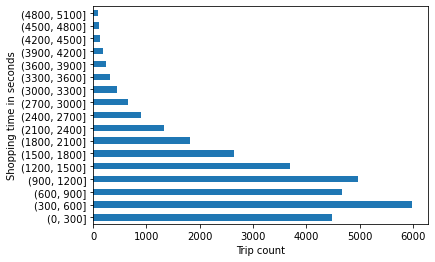

In [25]:
df.shopping_time.groupby(pd.cut(df.shopping_time, np.arange(0,5400,300))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Shopping time in seconds')
plt.show()

In [26]:
df.shopping_time.mean()

1161.2499541648842

In [33]:
plt.rcParams.update({'font.size': 12})


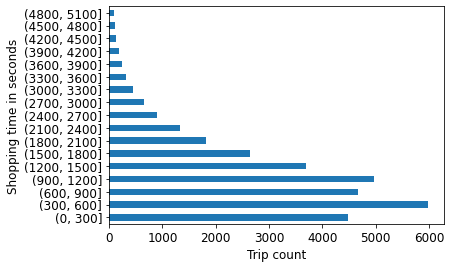

In [34]:
df.shopping_time.groupby(pd.cut(df.shopping_time, np.arange(0,5400,300))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Shopping time in seconds')
plt.show()

In [29]:
df['date_2'] = pd.to_datetime(df['date_1'])

In [38]:
af = df.sort_values(by = 'date_2')

af['str'] = df['date_2'].astype("string")


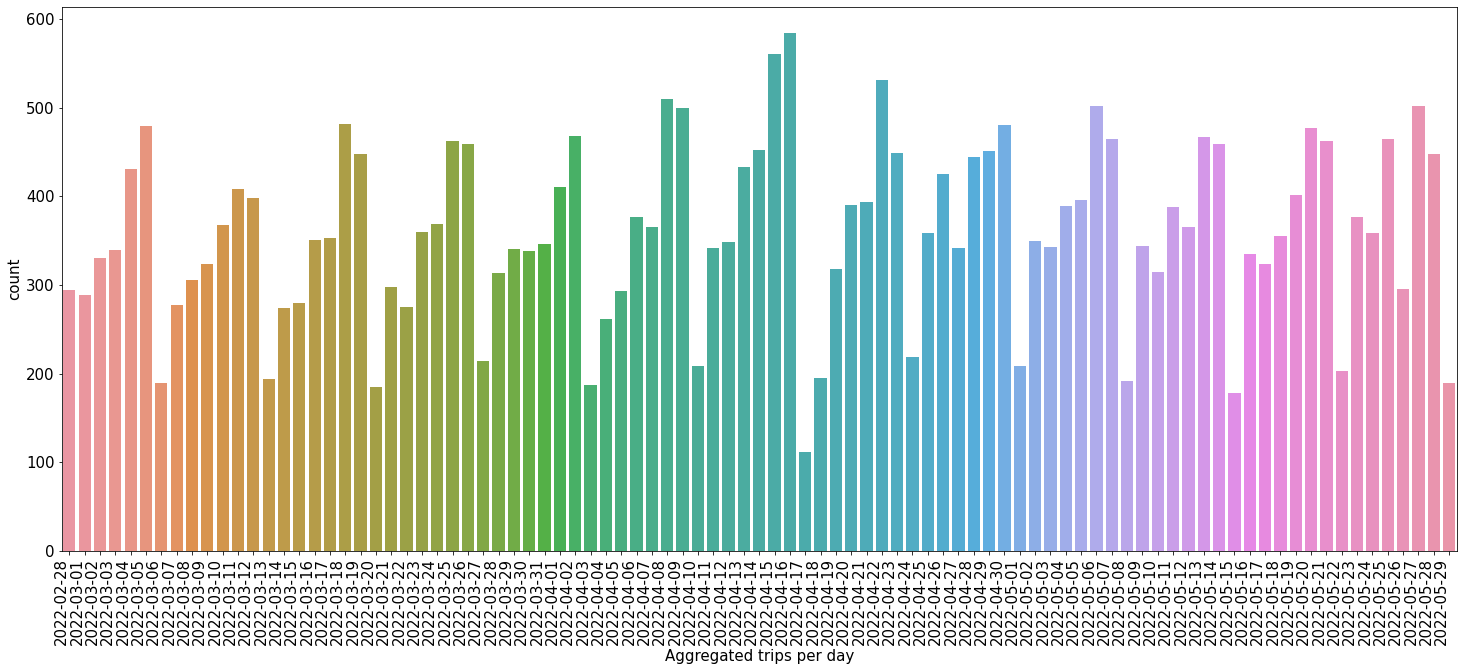

In [49]:
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(25, 10)) 
chart = sns.countplot(x = 'str', data = af)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right') 
plt.xlabel('Aggregated trips per day')
plt.show()


In [44]:
import matplotlib.pyplot as plt


<AxesSubplot:xlabel='day', ylabel='count'>

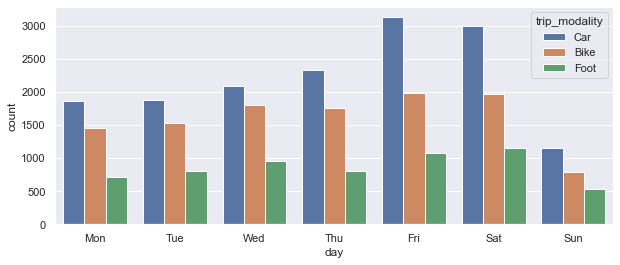

In [52]:
sns.set(rc={"figure.figsize":(10, 4)})
sns.countplot(x = 'day', data = df, order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], hue = 'trip_modality')

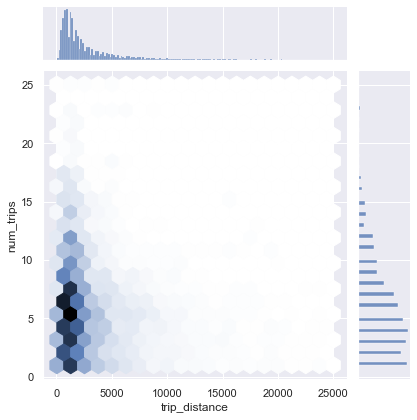

In [53]:
sns.jointplot(x='trip_distance',y='num_trips',data=df,kind='hex',gridsize=20)

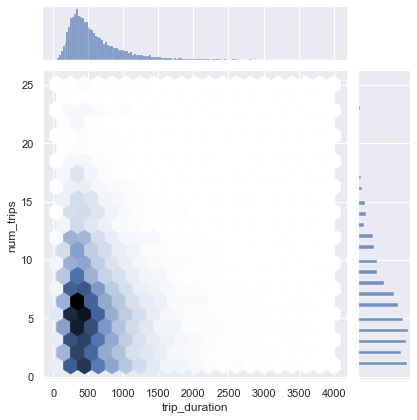

In [54]:
sns.jointplot(x='trip_duration',y='num_trips',data=df,kind='hex',gridsize=20)

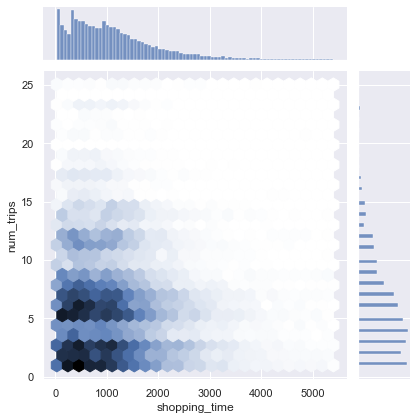

In [59]:
sns.jointplot(x='shopping_time',y='num_trips',data=df,kind='hex',gridsize=25)